In [2]:
from IPython.display import display, HTML

display(HTML('<style>.container { width:100% !important; }</style>'))

In [3]:
import os, cv2
import pickle, sys
import matplotlib.image as mpimg
import numpy as np
import keras
import transformers
import sklearn.metrics
import tensorflow as tf
import tqdm.notebook as tqdm
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import os
import shutil
import mtcnn

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
from ai_benchmark import AIBenchmark

benchmark = AIBenchmark()

results = benchmark.run()


>>   AI-Benchmark-v.0.1.2   
>>   Let the AI Games begin..

*  TF Version: 2.11.0
*  Platform: Windows-10-10.0.22000-SP0
*  CPU: N/A
*  CPU RAM: 31 GB

The benchmark is running...
The tests might take up to 20 minutes
Please don't interrupt the script

1/19. MobileNet-V2

1.1 - inference | batch=50, size=224x224: 468 ± 42 ms
1.2 - training  | batch=50, size=224x224: 2051 ± 197 ms

2/19. Inception-V3

2.1 - inference | batch=20, size=346x346: 808 ± 10 ms
2.2 - training  | batch=20, size=346x346: 4334 ± 20 ms

3/19. Inception-V4

3.1 - inference | batch=10, size=346x346: 864 ± 18 ms
3.2 - training  | batch=10, size=346x346: 4709 ± 70 ms

4/19. Inception-ResNet-V2



Load ViT transformer model from huggingface: https://huggingface.co/google/vit-base-patch32-224-in21k

In [3]:
IMAGE_SIZE = 224
shutil.rmtree('test_dataset')
shutil.rmtree('train_dataset')
shutil.rmtree('valid_dataset')

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch32-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


1/1 [==============================] - 0s 83ms/step


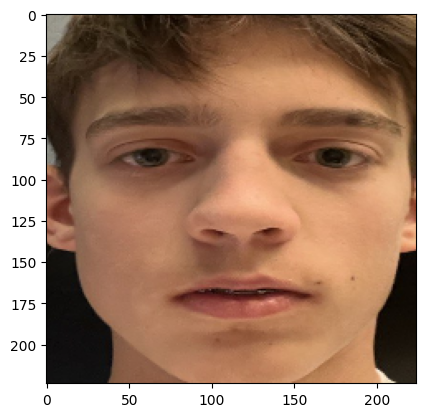

In [4]:
backbone = transformers.TFViTModel.from_pretrained('google/vit-base-patch32-224-in21k')
img = plt.imread('1.jpg')
face_detector = mtcnn.MTCNN()
face = face_detector.detect_faces(img)
if face:
    x1, y1, width, height = face[0]['box']
    x2, y2 = x1 + width, y1 + height
    img = cv2.resize(img[y1:y2, x1:x2], (224, 224))
    plt.imshow(img)

# Dataset preparation

Write a function that transforms images in a folder (train, valid, test) and saves ViT outputs as a [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset). Remember that images are read with values in range `[0, 255]`, but ViT model exppects image values to be in range `[0, 1]`. In addition ViT model expects inputs to have the shape `[N, C, H, W]`, but dataset outputs images with shape `[N, H, W, C]`. Don't forget that transformers models return an object instead of just array of data, so you need to use `pooler_output` field from it.

In [5]:
def prepare_dataset(images_path: str, output_path: str, batch_size: int = 32, shuffle: bool = True) -> None:
    '''Reads images from `image_path`, computes ViT output on them and saves the output with labels to `output_path` as tf.data.Dataset

    Arguments:
        image_path: path to read images from,
        output_path: path to save dataset to,
        batch_size: batch_size to use for image processing,
        shuffle:
    '''
    dataset = tf.keras.utils.image_dataset_from_directory(
        images_path,
        shuffle=shuffle,
        image_size=(224, 224),
        batch_size=batch_size
    )

    X, y = [], []

    for images, labels in tqdm.tqdm(dataset):
        images = images / 255
        images = tf.transpose(images, [0, 3, 1, 2])
        X.append(backbone.predict(images, verbose=0).pooler_output)
        y.append(labels)
    X = tf.concat(X, axis=0)
    y = tf.concat(y, axis=0)
    X_dataset = tf.data.Dataset.from_tensor_slices(X)
    y_dataset = tf.data.Dataset.from_tensor_slices(y)

    tf.data.Dataset.zip((X_dataset, y_dataset)).save(output_path)

Since images never change, we only need to compute ViT output on them once per image. Doing so before the actual model training increases training speed

In [6]:
prepare_dataset('train', 'train_dataset')
prepare_dataset('valid', 'valid_dataset', shuffle=False)
prepare_dataset('test', 'test_dataset', shuffle=False)

Found 1408 files belonging to 18 classes.


  0%|          | 0/44 [00:00<?, ?it/s]

Found 339 files belonging to 18 classes.


  0%|          | 0/11 [00:00<?, ?it/s]

Found 792 files belonging to 17 classes.


  0%|          | 0/25 [00:00<?, ?it/s]

In [7]:
train_dataset = tf.data.Dataset.load('train_dataset')
valid_dataset = tf.data.Dataset.load('valid_dataset')
test_dataset = tf.data.Dataset.load('test_dataset')

In [8]:
print(
    f'Number of train images: {len(train_dataset)}; Number of validation images: {len(valid_dataset)}; Number of test images: {len(test_dataset)}')

Number of train images: 1408; Number of validation images: 339; Number of test images: 792


Note the structure of the dataset. Each element is a pair: embedding vector of size 768 and a single class label

In [9]:
train_dataset.element_spec

(TensorSpec(shape=(768,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

# Build classification model

In [10]:
classes = os.listdir('train/')
num = len(classes)

tf.keras models are built as a graph, see more [here](https://www.tensorflow.org/guide/keras/functional).

First, make an input layer that accepts a vector of type tf.float32 and size 768.

In [11]:
inputs = tf.keras.layers.Input(shape=(768,), dtype=tf.float32, name='vit_embeddings')

Add at least one Dense layer, not that the size of the last vector must be equal to the number of classes and have a `softmax` activation

In [12]:
x = tf.keras.layers.Dense(units=num, activation='softmax')(inputs)

Finish constructing the model

In [13]:
model = tf.keras.models.Model(inputs=inputs, outputs=x, name='odnoklassniki_classifictaion_model')

In [14]:
model.summary()

Model: "odnoklassniki_classifictaion_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit_embeddings (InputLayer)  [(None, 768)]            0         
                                                                 
 dense_7 (Dense)             (None, 18)                13842     
                                                                 
Total params: 13,842
Trainable params: 13,842
Non-trainable params: 0
_________________________________________________________________


Compile the model. The loss is categorical crossentropy that expects ground truth to be class labels (sparse) rather than one hot vectors. Loss is [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam). The only metric is [Accuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy).

In [15]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

[Prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) and [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) the datasets.

In [16]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [17]:
BATCH_SIZE = 64

In [18]:
train_dataset = train_dataset.batch(BATCH_SIZE)
valid_dataset = valid_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Note the structure of the dataset. Each element is a pair of batched tensors: batch of embedding vectors of size 768 and a batch of class labels

In [19]:
train_dataset.element_spec

(TensorSpec(shape=(None, 768), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Prepare a [ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback to save the best model while training

In [20]:
MODEL_PATH = 'trained_model'

In [21]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(MODEL_PATH, save_best_only=True)]

Train the model

In [22]:
EPOCHS = 50

In [23]:
model.fit(train_dataset, validation_data=valid_dataset, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/50
 1/22 [>.............................] - ETA: 5s - loss: 2.9047 - accuracy: 0.0781

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 1s 30ms/step - loss: 2.5340 - accuracy: 0.2933 - val_loss: 2.2156 - val_accuracy: 0.4808
Epoch 2/50
 1/22 [>.............................] - ETA: 0s - loss: 2.0940 - accuracy: 0.5625

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 1.8240 - accuracy: 0.6939 - val_loss: 1.6972 - val_accuracy: 0.7080
Epoch 3/50
 1/22 [>.............................] - ETA: 0s - loss: 1.4870 - accuracy: 0.8750

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 1.3606 - accuracy: 0.8551 - val_loss: 1.3592 - val_accuracy: 0.8112
Epoch 4/50
 1/22 [>.............................] - ETA: 0s - loss: 1.1462 - accuracy: 0.9531

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 14ms/step - loss: 1.0585 - accuracy: 0.9105 - val_loss: 1.1246 - val_accuracy: 0.8496
Epoch 5/50
 1/22 [>.............................] - ETA: 0s - loss: 0.9009 - accuracy: 0.9531

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 14ms/step - loss: 0.8495 - accuracy: 0.9361 - val_loss: 0.9580 - val_accuracy: 0.8761
Epoch 6/50
 1/22 [>.............................] - ETA: 0s - loss: 0.7292 - accuracy: 0.9531

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 14ms/step - loss: 0.6998 - accuracy: 0.9517 - val_loss: 0.8349 - val_accuracy: 0.8997
Epoch 7/50
 1/22 [>.............................] - ETA: 0s - loss: 0.6035 - accuracy: 0.9688

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.5891 - accuracy: 0.9602 - val_loss: 0.7415 - val_accuracy: 0.9056
Epoch 8/50
 1/22 [>.............................] - ETA: 0s - loss: 0.5089 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.5046 - accuracy: 0.9695 - val_loss: 0.6685 - val_accuracy: 0.9086
Epoch 9/50
 1/22 [>.............................] - ETA: 0s - loss: 0.4360 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.4384 - accuracy: 0.9744 - val_loss: 0.6104 - val_accuracy: 0.9145
Epoch 10/50
 1/22 [>.............................] - ETA: 0s - loss: 0.3787 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.3854 - accuracy: 0.9787 - val_loss: 0.5630 - val_accuracy: 0.9174
Epoch 11/50
 1/22 [>.............................] - ETA: 0s - loss: 0.3327 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 14ms/step - loss: 0.3421 - accuracy: 0.9822 - val_loss: 0.5239 - val_accuracy: 0.9292
Epoch 12/50
 1/22 [>.............................] - ETA: 0s - loss: 0.2953 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.3062 - accuracy: 0.9830 - val_loss: 0.4911 - val_accuracy: 0.9292
Epoch 13/50
 1/22 [>.............................] - ETA: 0s - loss: 0.2644 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.2760 - accuracy: 0.9844 - val_loss: 0.4633 - val_accuracy: 0.9322
Epoch 14/50
 1/22 [>.............................] - ETA: 0s - loss: 0.2385 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 14ms/step - loss: 0.2504 - accuracy: 0.9865 - val_loss: 0.4394 - val_accuracy: 0.9351
Epoch 15/50
 1/22 [>.............................] - ETA: 0s - loss: 0.2166 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.2284 - accuracy: 0.9879 - val_loss: 0.4187 - val_accuracy: 0.9410
Epoch 16/50
 1/22 [>.............................] - ETA: 0s - loss: 0.1979 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.2093 - accuracy: 0.9908 - val_loss: 0.4007 - val_accuracy: 0.9410
Epoch 17/50
 1/22 [>.............................] - ETA: 0s - loss: 0.1818 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.1926 - accuracy: 0.9915 - val_loss: 0.3848 - val_accuracy: 0.9410
Epoch 18/50
 1/22 [>.............................] - ETA: 0s - loss: 0.1677 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.1780 - accuracy: 0.9915 - val_loss: 0.3707 - val_accuracy: 0.9469
Epoch 19/50
 1/22 [>.............................] - ETA: 0s - loss: 0.1554 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.1650 - accuracy: 0.9915 - val_loss: 0.3582 - val_accuracy: 0.9469
Epoch 20/50
 1/22 [>.............................] - ETA: 0s - loss: 0.1445 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.1534 - accuracy: 0.9950 - val_loss: 0.3470 - val_accuracy: 0.9469
Epoch 21/50
 1/22 [>.............................] - ETA: 0s - loss: 0.1348 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.1431 - accuracy: 0.9957 - val_loss: 0.3369 - val_accuracy: 0.9469
Epoch 22/50
 1/22 [>.............................] - ETA: 0s - loss: 0.1262 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.1337 - accuracy: 0.9964 - val_loss: 0.3277 - val_accuracy: 0.9469
Epoch 23/50
 1/22 [>.............................] - ETA: 0s - loss: 0.1184 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 14ms/step - loss: 0.1253 - accuracy: 0.9979 - val_loss: 0.3195 - val_accuracy: 0.9469
Epoch 24/50
 1/22 [>.............................] - ETA: 0s - loss: 0.1114 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 14ms/step - loss: 0.1177 - accuracy: 0.9986 - val_loss: 0.3119 - val_accuracy: 0.9469
Epoch 25/50
 1/22 [>.............................] - ETA: 0s - loss: 0.1051 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.1108 - accuracy: 0.9986 - val_loss: 0.3050 - val_accuracy: 0.9469
Epoch 26/50
 1/22 [>.............................] - ETA: 0s - loss: 0.0993 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 14ms/step - loss: 0.1045 - accuracy: 0.9986 - val_loss: 0.2987 - val_accuracy: 0.9469
Epoch 27/50
 1/22 [>.............................] - ETA: 0s - loss: 0.0940 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 14ms/step - loss: 0.0987 - accuracy: 0.9986 - val_loss: 0.2929 - val_accuracy: 0.9469
Epoch 28/50
 1/22 [>.............................] - ETA: 0s - loss: 0.0892 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.0934 - accuracy: 0.9993 - val_loss: 0.2875 - val_accuracy: 0.9469
Epoch 29/50
 1/22 [>.............................] - ETA: 0s - loss: 0.0847 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 1s 24ms/step - loss: 0.0886 - accuracy: 0.9993 - val_loss: 0.2825 - val_accuracy: 0.9469
Epoch 30/50
 1/22 [>.............................] - ETA: 0s - loss: 0.0806 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 14ms/step - loss: 0.0841 - accuracy: 0.9993 - val_loss: 0.2779 - val_accuracy: 0.9469
Epoch 31/50
 1/22 [>.............................] - ETA: 0s - loss: 0.0768 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.0799 - accuracy: 0.9993 - val_loss: 0.2736 - val_accuracy: 0.9469
Epoch 32/50
 1/22 [>.............................] - ETA: 0s - loss: 0.0733 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 14ms/step - loss: 0.0761 - accuracy: 1.0000 - val_loss: 0.2696 - val_accuracy: 0.9469
Epoch 33/50
 1/22 [>.............................] - ETA: 0s - loss: 0.0701 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 14ms/step - loss: 0.0725 - accuracy: 1.0000 - val_loss: 0.2659 - val_accuracy: 0.9469
Epoch 34/50
 1/22 [>.............................] - ETA: 0s - loss: 0.0670 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 15ms/step - loss: 0.0692 - accuracy: 1.0000 - val_loss: 0.2624 - val_accuracy: 0.9499
Epoch 35/50
 1/22 [>.............................] - ETA: 0s - loss: 0.0642 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 17ms/step - loss: 0.0662 - accuracy: 1.0000 - val_loss: 0.2592 - val_accuracy: 0.9499
Epoch 36/50
 1/22 [>.............................] - ETA: 0s - loss: 0.0615 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 17ms/step - loss: 0.0633 - accuracy: 1.0000 - val_loss: 0.2561 - val_accuracy: 0.9499
Epoch 37/50
 1/22 [>.............................] - ETA: 0s - loss: 0.0591 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 15ms/step - loss: 0.0606 - accuracy: 1.0000 - val_loss: 0.2532 - val_accuracy: 0.9499
Epoch 38/50
 1/22 [>.............................] - ETA: 0s - loss: 0.0567 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 14ms/step - loss: 0.0581 - accuracy: 1.0000 - val_loss: 0.2505 - val_accuracy: 0.9499
Epoch 39/50
 1/22 [>.............................] - ETA: 0s - loss: 0.0546 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.0557 - accuracy: 1.0000 - val_loss: 0.2480 - val_accuracy: 0.9499
Epoch 40/50
 1/22 [>.............................] - ETA: 0s - loss: 0.0525 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.0535 - accuracy: 1.0000 - val_loss: 0.2456 - val_accuracy: 0.9499
Epoch 41/50
 1/22 [>.............................] - ETA: 0s - loss: 0.0506 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.0514 - accuracy: 1.0000 - val_loss: 0.2433 - val_accuracy: 0.9499
Epoch 42/50
 1/22 [>.............................] - ETA: 0s - loss: 0.0487 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.0495 - accuracy: 1.0000 - val_loss: 0.2411 - val_accuracy: 0.9528
Epoch 43/50
 1/22 [>.............................] - ETA: 0s - loss: 0.0470 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.0476 - accuracy: 1.0000 - val_loss: 0.2391 - val_accuracy: 0.9528
Epoch 44/50
 1/22 [>.............................] - ETA: 0s - loss: 0.0454 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.0459 - accuracy: 1.0000 - val_loss: 0.2372 - val_accuracy: 0.9528
Epoch 45/50
 1/22 [>.............................] - ETA: 0s - loss: 0.0438 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.0442 - accuracy: 1.0000 - val_loss: 0.2353 - val_accuracy: 0.9528
Epoch 46/50
 1/22 [>.............................] - ETA: 0s - loss: 0.0423 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.0427 - accuracy: 1.0000 - val_loss: 0.2336 - val_accuracy: 0.9528
Epoch 47/50
 1/22 [>.............................] - ETA: 0s - loss: 0.0410 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.0412 - accuracy: 1.0000 - val_loss: 0.2319 - val_accuracy: 0.9528
Epoch 48/50
 1/22 [>.............................] - ETA: 0s - loss: 0.0396 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.0398 - accuracy: 1.0000 - val_loss: 0.2304 - val_accuracy: 0.9528
Epoch 49/50
 1/22 [>.............................] - ETA: 0s - loss: 0.0384 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.0385 - accuracy: 1.0000 - val_loss: 0.2289 - val_accuracy: 0.9528
Epoch 50/50
 1/22 [>.............................] - ETA: 0s - loss: 0.0372 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


22/22 [==============================] - 0s 13ms/step - loss: 0.0372 - accuracy: 1.0000 - val_loss: 0.2274 - val_accuracy: 0.9528


Evaluate model on the test dataset

In [24]:
model.evaluate(x=test_dataset)

13/13 [==============================] - 0s 1ms/step - loss: 6.9903 - accuracy: 0.0189


[6.9903059005737305, 0.018939394503831863]

Plot confusion matrix on combined valid and test dataset using [ConfusionMatrixDisplay.from_predictions](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions)

In [25]:
combined_dataset = valid_dataset.concatenate(test_dataset)

In [26]:
y_pred = np.argmax(model.predict(combined_dataset), axis=-1)

19/19 [==============================] - 0s 2ms/step


In [27]:
y_true = np.concatenate([i[1] for i in combined_dataset])

The resulting image is VERY LARGY so drawing takes a significant amount of time

In [28]:
# _, ax = plt.subplots(figsize=(150, 150))
# sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax, colorbar=False)
# plt.savefig('confusion_matrix.png')
# plt.show()

# Testing on images from the internet

First, make a function that reads an image from disk, resizes and normalizes it. You're only allowed to use tensorflow functions

In [29]:
model = tf.keras.models.load_model('trained_model')

In [30]:
def read_image(path: str) -> tf.Tensor:
    '''Reads image to tf.Tensor
    
    Arguments:
        path: path to read image from
        
    Returns:
        tf.Tensor with shape [H, W, C] and values in range [0, 1]
    
    '''
    img = tf.keras.utils.load_img(path)
    # img = tf.keras.utils.img_to_array(img)
    img = np.asarray(img)
    face_detector = mtcnn.MTCNN()
    face = face_detector.detect_faces(img)
    if face:
        x1, y1, width, height = face[0]['box']
        x2, y2 = x1 + width, y1 + height
        img = cv2.resize(img[y1:y2, x1:x2], (224, 224))
        plt.imshow(img)
    input_arr = img / 255
    input_arr = tf.image.resize(input_arr, [224, 224])
    input_arr = tf.convert_to_tensor(input_arr, dtype=tf.float32)
    return input_arr

/# LOAD MODEL FROM DISK

1/1 [==============================] - 0s 91ms/step


<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.84705883, 0.78039217, 0.7176471 ],
        [0.80784315, 0.7411765 , 0.67058825],
        [0.69411767, 0.62352943, 0.5568628 ],
        ...,
        [0.07843138, 0.04705882, 0.00392157],
        [0.09411765, 0.0627451 , 0.01568628],
        [0.10588235, 0.07450981, 0.02352941]],

       [[0.85882354, 0.7921569 , 0.7254902 ],
        [0.8235294 , 0.75686276, 0.6862745 ],
        [0.7058824 , 0.63529414, 0.5647059 ],
        ...,
        [0.0627451 , 0.03137255, 0.        ],
        [0.07450981, 0.04313726, 0.00392157],
        [0.09019608, 0.05882353, 0.00784314]],

       [[0.8117647 , 0.74509805, 0.6784314 ],
        [0.8666667 , 0.8       , 0.7294118 ],
        [0.78431374, 0.7137255 , 0.64705884],
        ...,
        [0.05882353, 0.02352941, 0.        ],
        [0.06666667, 0.03529412, 0.        ],
        [0.07843138, 0.04705882, 0.00392157]],

       ...,

       [[0.80784315, 0.7019608 , 0.6156863 ],
        [0.84

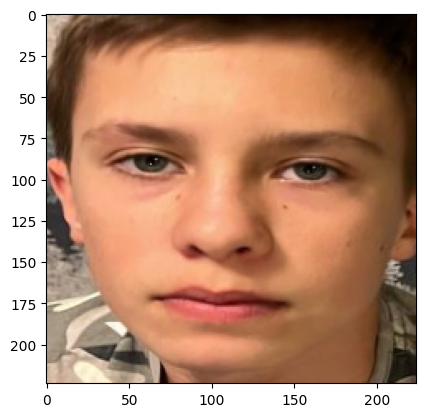

In [31]:
read_image('2.jpg')

In [32]:
classes = os.listdir('train/')
classes

['Arhip Nikolaev',
 'Arkadii Kasper',
 'Asia Alexeeva',
 'Damir Magomedov',
 'Dasha Sorokina',
 'Edik Sushkov',
 'Egor Golubchikov',
 'Gleb Karitskii',
 'Ivan Beliaev',
 'Kirill Sannikov',
 'Kirill Shaufler',
 'Kozitskii Alexander',
 'Leonid Dronov',
 'Matvei Beliaev',
 'Minsu',
 'Taisia Yurova',
 'Vlad Peleganchuk',
 'Vova Titkov']

Now make a new model that combines ViT model and the one you just trained. This time your model expects an image tensor of shape `[H, W, C]` and type `tf.float32`. The values `H, W, C` must be replaced with actual values depending on the size of input images

In [33]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='image_input')

Transpose image to fit requirements

In [34]:
x = tf.keras.layers.Lambda(lambda x: tf.transpose(x, [0, 3, 1, 2]), name='transpose')(inputs)

Get output from ViT model, remember `pooler_output`

In [35]:
x = backbone(x).pooler_output

Get output from the model you trained

In [36]:
x = model(x)

Make evaluation model

In [37]:
evaluation_model = tf.keras.models.Model(inputs=inputs, outputs=x, name='evaluation_model')

Make a function that accepts a path to some image, predicts model output on it and displays image with predicted class caption and probability. Don't forget to use `predict` function and remember that model expects batched input, so data passed to model must be of shape `[1, H, W, C]`

In [38]:
def get_image_class(path: str, ax) -> None:
    '''Gets model output for image specified by `path` and plots the result.
    
    Arguments:
        path: path to image to be tested
    '''
    ax.axis('off')
    image = read_image(path)
    image = tf.expand_dims(image, axis=0)
    pred = evaluation_model.predict(image)
    img = plt.imread(path)
    ax.imshow(img)
    ax.set_title(f'{classes[pred[0].argmax()]} - {pred[0].max() * 100}%')

In [39]:
%matplotlib inline

UsageError: Line magic function `%` not found.


In [ ]:
get_image_class('6.jpg', plt.gca())

1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 92ms/step


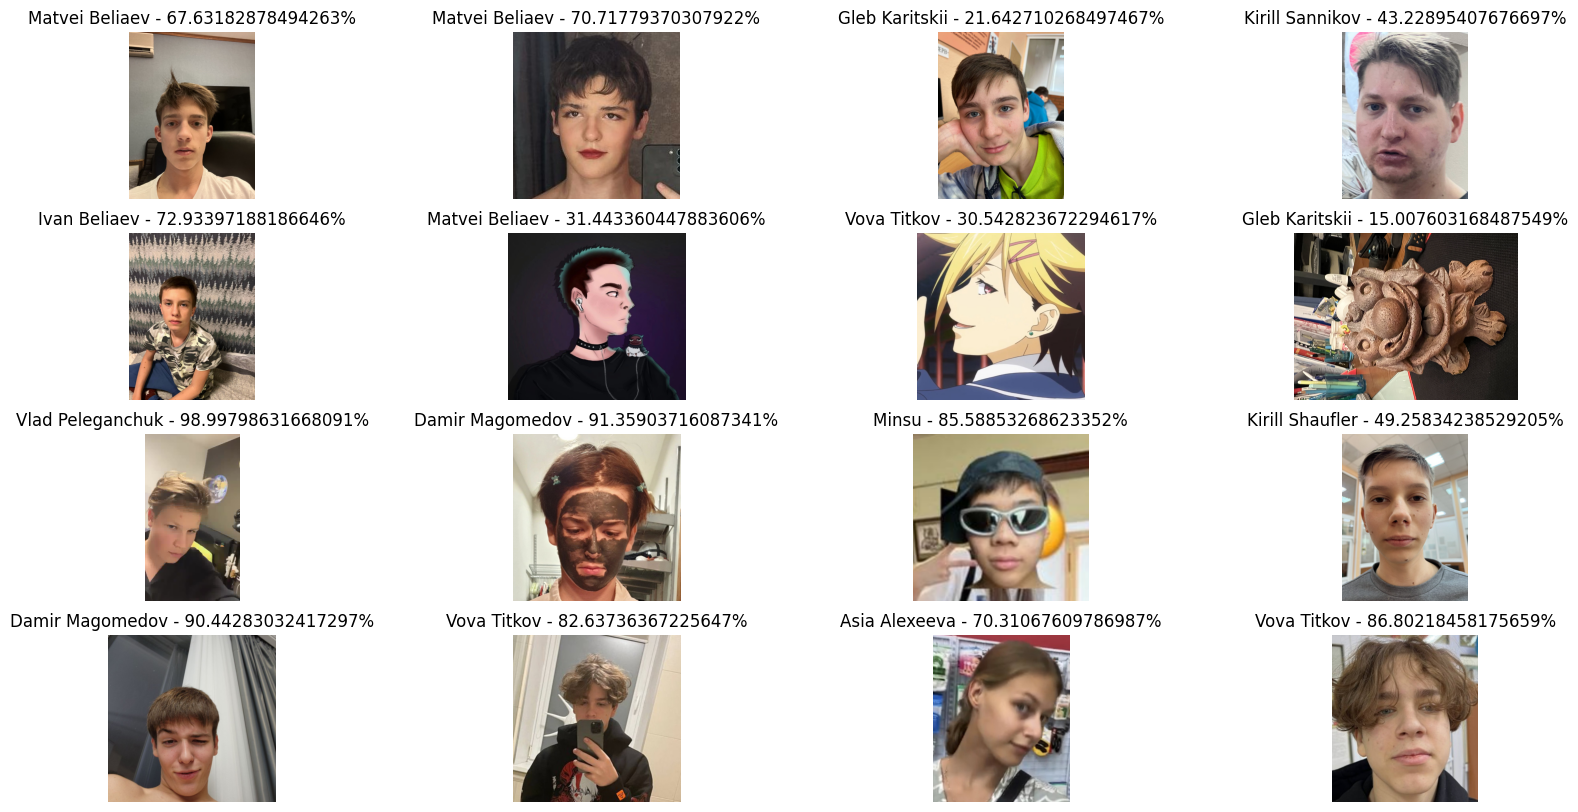

In [40]:
_, ax = plt.subplots(ncols=4, nrows=4, figsize=(20, 10))
n = 1
for i in range(4):
    for g in range(4):
        get_image_class(f'{n}.jpg', ax[g][i])
        n += 1